# Assignment 2 
- 1D 2 class Gaussian Discriminent
- 2D 2 class Gaussian Discriminent
- kD k class Gaussian Discriminent
### setting all the imports


In [181]:
# all imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import re
from sklearn import datasets, linear_model
from sklearn.cross_validation import KFold    
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from numpy.linalg import inv
from sklearn.preprocessing import PolynomialFeatures
import collections # this is used to perform the collection  based sorting  and unique element identification
from sklearn.cross_validation import train_test_split #  this is used for cross validation 
from functools import partial # this is to accomdate partials
import random
from numpy.linalg import det
import math
from numpy import log
from sklearn.metrics import precision_recall_curve

### This a class tha twould be used to test the data set

In [182]:
class TestMetrics:
    
    def setData(self,y_test,y_pred_class):
            self.y_test = y_test
            self.y_pred_class = y_pred_class
            print 'True:', y_test
            print 'Pred:', y_pred_class
        
    def getMatrics(self):
        #print metrics.accuracy_score(self.y_test, self.y_pred_class)
        # save confusion matrix and slice into four pieces
        confusion = metrics.confusion_matrix(self.y_test, self.y_pred_class)
#       print "confusion matrix:",confusion
        TP = confusion[1, 1]
        TN = confusion[0, 0]
        FP = confusion[0, 1]
        FN = confusion[1, 0]
        if math.isnan(TP):
            print "tp is nan"
            TP = 0
        if math.isnan(TN):
            print "tn is nan"
            TN = 0
        if math.isnan(FP):
            print "fp is nan"
            FP = 0
        if math.isnan(FN):
            print " is nan"
            FN = 0       

        #Classification Accuracy: Overall, how often is the classifier correct?
        #Classification_Accuracy = (TP + TN) / float(TP + TN + FP + FN)
        Classification_Accuracy = metrics.accuracy_score(self.y_test, self.y_pred_class)
        #print "#Classification Accuracy:\t",Classification_Accuracy
       
        #Classification Error: Overall, how often is the classifier incorrect?
        #Classification_Error = (FP + FN) / float(TP + TN + FP + FN)
        Classification_Error =  1 - metrics.accuracy_score(self.y_test, self.y_pred_class)
        
        #Sensitivity:
        Sensitivity = TP / float(TP + FN)
        #print "#Sensitivity:\t",Sensitivity
        #Specificity: 
        Specificity = TN / float(TN + FP) 
        #print "#Specificity:\t",Specificity
        #False Positive Rate:
        False_Positive_Rate = FP / float(TN + FP)
        #print "#False Positive Rate:",False_Positive_Rate
        #Precision: 
        #Precision = TP / float(TP + FP)
        Precision = metrics.precision_score(self.y_test, self.y_pred_class)
        #print "#Precision:\t",Precision
        #print metrics.precision_score(y_test, y_pred_class)
        #print TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision
        return TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision
#test        
# tm  = TestMetrics()
# tm.setData(Y,Y)
# tm.getMatrics()

In [183]:
# fetching all data

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:]  # we only take the first two features.
Y = iris.target

numberOfClass = lambda listValues :list(set(listValues))# this is the number of classes in each dataset

m = lambda listValues: collections.Counter(listValues)

idf = lambda currentClass,itratingClass : (0,1)[currentClass == itratingClass] # this is the indicator function

mean = lambda X_D,Y_D:[np.mean([idf(Y_D[rowIndex],classElement)*rowElements for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1],axis = 0) for classIndex ,classElement in enumerate(numberOfClass(Y_D))]

varience =lambda X_D,Y_D:[np.var([idf(Y_D[rowIndex],classElement)*rowElements for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1],axis = 0) for classIndex ,classElement in enumerate(numberOfClass(Y_D))]

alpha = lambda X_D,Y_D:[m(Y_1D)[classElement]*1.0/len(Y_D) for classElement in (numberOfClass(Y_D))]
# this is for 1D calculation
g = lambda x,var,mean,alpha: np.log2(alpha)- (((x-mean)**2)/2*(var**2))

covVar =  lambda X_D,Y_D:[np.cov(np.asarray([list(idf(Y_D[rowIndex],classElement)*rowElements) for rowIndex,rowElements in enumerate(X_D)if idf(Y_D[rowIndex],classElement)== 1]).T) for classIndex,classElement in enumerate(numberOfClass(Y_D))]

g_multiVariate = lambda x,co_var_mat,mean,aph: (-1.0*np.log((2*np.pi)**x.shape[1])) - (1.0*np.log(det(co_var_mat)))-(0.5*np.dot(np.dot((x-mean),inv(co_var_mat)),(x-mean).T)) +log(aph)

                                        
def discriminent (x, a_class, b_class):
    sendX = (np.asarray([x])) # sending x as a collection of rows vector
    if (a_class(sendX)>b_class(sendX)) :
        return 0
    else :
        return 1


def discriminent_1 (x, a_class, b_class,c_class):
    sendX = (np.array([x])) # sending x as a collection of rows vector

    if ((a_class(sendX) > b_class(sendX)))and ((a_class(sendX)>c_class(sendX))):
        return 0
    elif((b_class(sendX)>c_class(sendX))>0):
        return 1
    else:
        return 2


In [184]:
class GDA1D2C:
    #this si to fit the existing data
    def fit(self,Xdata,Ydata):
        self.XData = Xdata
        self.YData = Ydata
        #step:1 - find alpha
        self.alpha = alpha(Xdata,Ydata)
        #step:2 - find mean 
        self.mean = mean(Xdata,Ydata)
        print "mean",self.mean
        #step:3 - find varience
        self.varience = varience(Xdata,Ydata)
        print"varience",self.varience
        #step:4
        g0 = partial(g,var = self.varience[0],mean= self.mean[0],alpha= self.alpha[0])
        g1 = partial(g,var = self.varience[1],mean= self.mean[1],alpha= self.alpha[1])
        #step:5
        self.discriminent = partial(discriminent,a_class = g0, b_class = g1)
    def predict(self,XD):
        return [self.discriminent(xvalue) for xvalue in XD]

In [185]:
class GDAnD2C:
    #this si to fit the existing data
    def fit(self,Xdata,Ydata):
        self.XData = Xdata
        self.YData = Ydata
    
        #step:1 - find alpha
        self.alpha = alpha(Xdata,Ydata)
        #step:2 - find mean 
        self.mean = mean(Xdata,Ydata)
        #print "mean",self.mean
        
        #step:3 - find co_varience
        self.co_varience = covVar(Xdata,Ydata)
        #print"co varience matix",self.co_varience
        

        ## sending the mean as transposed
        self.g0 = partial(g_multiVariate,aph = self.alpha[0],co_var_mat = self.co_varience[0],mean= (np.asarray([self.mean[0]])))
        self.g1 = partial(g_multiVariate,aph = self.alpha[1],co_var_mat = self.co_varience[1],mean= (np.asarray([self.mean[1]])))
        #step:5
        self.discriminent = partial(discriminent,a_class = self.g0, b_class = self.g1)
        #self.discriminent = partial(discriminent,a_class = partial(g,varience = self.varience[0],mean= self.mean[0],alpha= self.alpha[0]), b_class = partial(g,varience = self.varience[1],mean= self.mean[1],alpha= self.alpha[1]))
    # this is to predict y data  from the give X data
    def predict(self,XD):
        return [self.discriminent(xvalue) for xvalue in XD]

In [ ]:
class GDAnD3C:
    def fit(self,Xdata,Ydata):
        self.XData = Xdata
        self.YData = Ydata
        #step:1 - find alpha
        self.alpha = alpha(Xdata,Ydata)
    
        #step:2 - find mean 
        self.mean = mean(Xdata,Ydata)
        #print "mean",self.mean
        
        #step:3 - find co_varience
        self.co_varience = covVar(Xdata,Ydata)
        #print"co varience matix",self.co_varience

        
        ## sending the mean as transposed
        self.g0 = partial(g_multiVariate,aph = self.alpha[0],co_var_mat = self.co_varience[0],mean= (np.asarray([self.mean[0]])))
        self.g1 = partial(g_multiVariate,aph = self.alpha[1],co_var_mat = self.co_varience[1],mean= (np.asarray([self.mean[1]])))
        self.g2 = partial(g_multiVariate,aph = self.alpha[2],co_var_mat = self.co_varience[2],mean= (np.asarray([self.mean[2]])))

        #step:5
        self.discriminent = partial(discriminent_1,a_class = self.g0, b_class = self.g1, c_class = self.g2)


    def predict(self,XD):
        return [self.discriminent(xvalue) for xvalue in XD]

# Checking with 2 class 1 features Gaussian discreminent

mean [array([ 4.97142857]), array([ 5.93333333])]
varience [array([ 0.13394558]), array([ 0.26513889])]
True: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
mean [array([ 5.02888889]), array([ 5.98222222])]
varience [array([ 0.12516543]), array([ 0.24057284])]
True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
mean [array([ 5.0326087]), array([ 5.925])]
varience [array([ 0.11611059]), array([ 0.28551136])]
True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
mean [array([ 5.00666667]), array([ 5.90666667])]
varience [array([ 0.12951111]), array([ 0.24906667])]
True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
mean [array([ 4.99772727]), array([ 5.92391304])]
varience [array([ 0.11158574]), array([ 0.26094991])]
True: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Pred: [0, 0, 1, 0, 0, 0, 0, 1, 1, 1]
mean [array([ 5.00851064]), array([ 5.96976744])]
varience [array([ 0.12843821]), array([ 0.25466739])]
True: [0, 0,

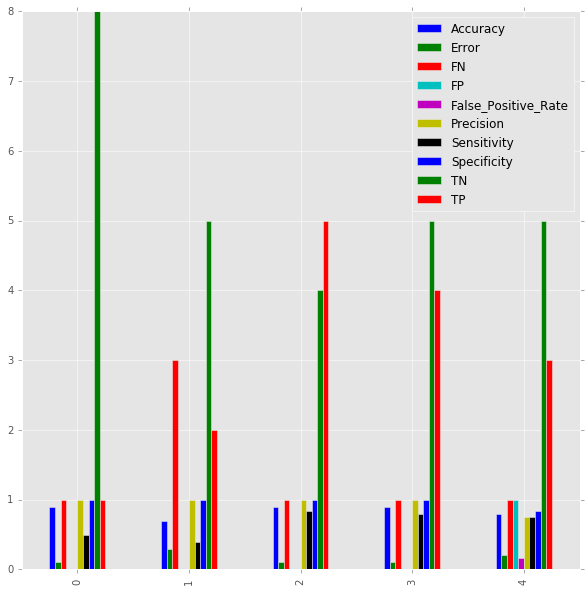

In [186]:
X_1D = X[:100,:1]# this is to take one feature and first 100 data sets
Y_1D = Y [:100] # this is to take 1st 100 data sets


matricsTotal = []
kf = sklearn.cross_validation.KFold(n=len(Y_1D), n_folds=10, shuffle=True,random_state=5)
for train_index, test_index in kf:
    X_train, X_test =[list(X_1D[a]) for a  in train_index],[list(X_1D[a]) for a  in test_index]
    Y_train, Y_test = [Y_1D[a] for a  in train_index],[Y_1D[a] for a  in test_index]

    grad =  GDA1D2C()
    grad.fit(X_train,Y_train)
    predicted_Y_values = grad.predict(X_test)
    tm  = TestMetrics()
    tm.setData(Y_test,predicted_Y_values)
    TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  tm.getMatrics()
    matricsTotal.append({"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})


df = pd.DataFrame(matricsTotal).head()

matplotlib.style.use('ggplot')
#df.plot.figure(figsize=(50,50))
df.plot(kind = 'bar',figsize =(10 ,10),stacked = False)

print df

# Checking with 2 class n features Gaussian discreminent

True: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


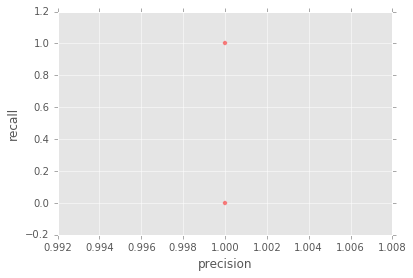

True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


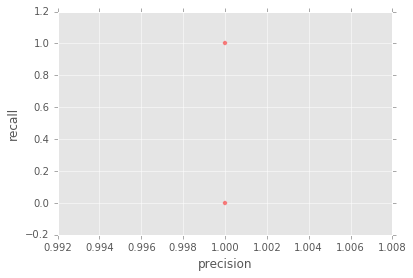

True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


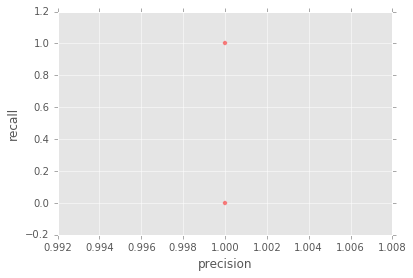

True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


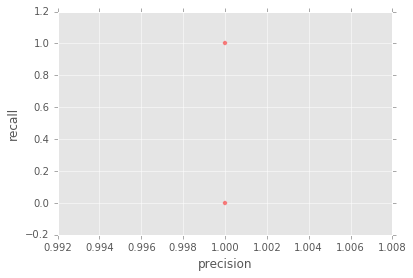

True: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


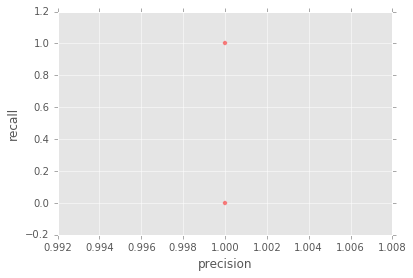

True: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


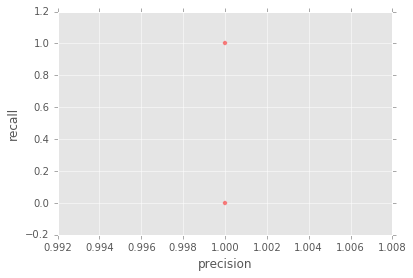

True: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


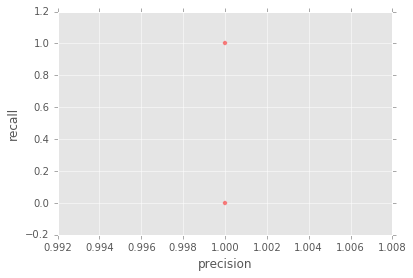

True: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]


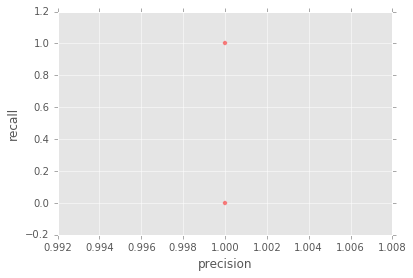

True: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


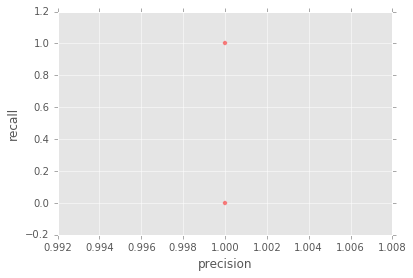

True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]


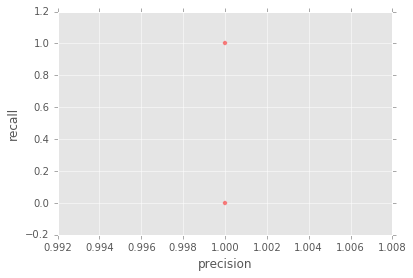

   Accuracy  Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0         1      0   0   0                    0          1            1   
1         1      0   0   0                    0          1            1   
2         1      0   0   0                    0          1            1   
3         1      0   0   0                    0          1            1   
4         1      0   0   0                    0          1            1   

   Specificity  TN  TP  
0            1   8   2  
1            1   5   5  
2            1   4   6  
3            1   5   5  
4            1   6   4  


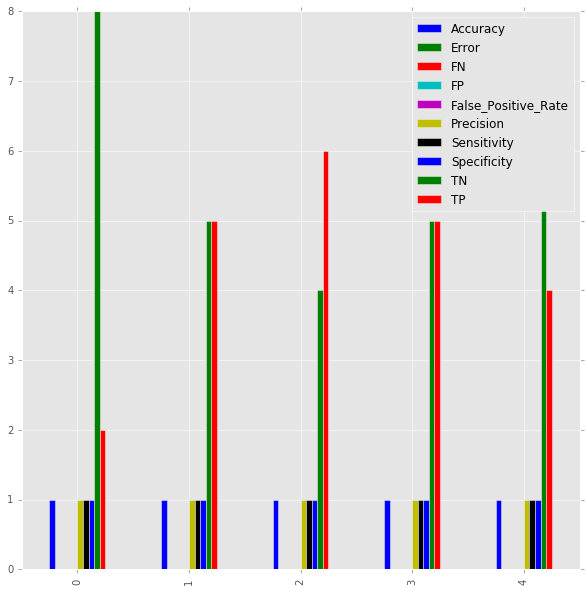

In [193]:
X_2D = X[:100,:]# this is to take one feature and first 100 data sets
Y_2D = Y [:100] # this is to take 1st 100 data sets

matricsTotal = []
kf = sklearn.cross_validation.KFold(n=len(Y_1D), n_folds=10, shuffle=True,random_state=5)
for train_index, test_index in kf:
    X_train, X_test =[X_2D[a] for a  in train_index],[X_2D[a] for a  in test_index]
    Y_train, Y_test = [Y_2D[a] for a  in train_index],[Y_2D[a] for a  in test_index]

    grad =  GDAnD2C()
    grad.fit(X_train,Y_train)
    predicted_Y_values = grad.predict(X_test)
    tm  = TestMetrics()
    tm.setData(Y_test,predicted_Y_values)
    TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  tm.getMatrics()
    matricsTotal.append({"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})
    precision, recall, thresholds = precision_recall_curve(Y_test, predicted_Y_values)
    plt.scatter(precision, recall, c="red", alpha=0.5)
    plt.xlabel("precision")
    plt.ylabel("recall")
    plt.show()
    

df = pd.DataFrame(matricsTotal).head()
matplotlib.style.use('ggplot')
#df.plot.figure(figsize=(50,50))
df.plot(kind = 'bar',figsize =(10 ,10),stacked = False)

print df

# Checking with n class n features Gaussian discreminent

True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True:

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Ana

 [0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2]
Pred: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
True: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2]
Pred: [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
   Accuracy     Error  FN  FP  False_Positive_Rate  Precision  Sensitivity  \
0  0.733333  0.266667   0   0                    0   0.563636            1   
1  0.600000  0.400000   0   0                    0   0.418182            1   
2  0.733333  0.266667   0   0                    0   0.573333            1   
3  0.600000  0.400000   0   0                    0   0.466667            1   
4  0.800000  0.200000   0   0                    0   0.660000            1   

   Specificity  TN  TP  
0            1   4   7  
1            1   4   5  
2            1   5   6  
3            1   6  

C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Ana

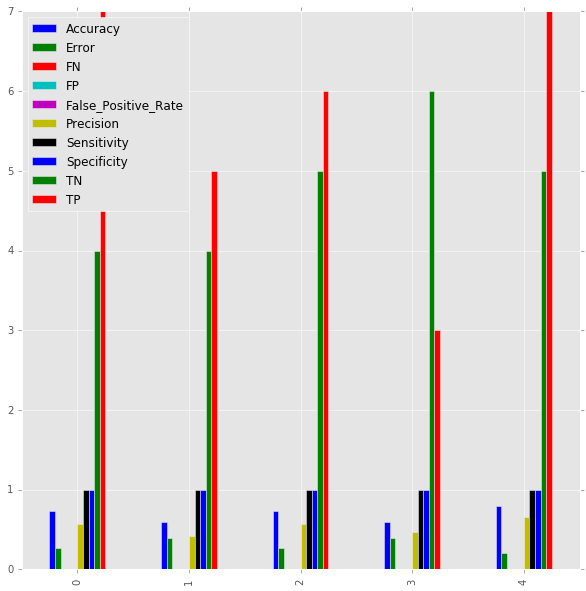

In [192]:
X_nD = X[:,:]# this is to take one feature and first 100 data sets
Y_nD = Y [:] # this is to take 1st 100 data sets

matricsTotal = []
kf = sklearn.cross_validation.KFold(n=len(Y_nD), n_folds=10, shuffle=True)
for train_index, test_index in kf:
    X_train, X_test =[X_nD[a] for a  in train_index],[X_nD[a] for a  in test_index]
    Y_train, Y_test = [Y_nD[a] for a  in train_index],[Y_nD[a] for a  in test_index]

    grad =  GDAnD3C()
    grad.fit(X_train,Y_train)
    predicted_Y_values = grad.predict(X_test)
    tm  = TestMetrics()
    tm.setData(Y_test,predicted_Y_values)
    TP,TN,FP,FN,Classification_Accuracy,Classification_Error,Sensitivity,Specificity,False_Positive_Rate,Precision =  tm.getMatrics()
    matricsTotal.append({"TP":TP,"TN":TN,"FP":FP,"FN":FN,"Accuracy":Classification_Accuracy,"Error":Classification_Error,"Sensitivity":Sensitivity,"Specificity":Specificity,"False_Positive_Rate":False_Positive_Rate,"Precision":Precision})


df = pd.DataFrame(matricsTotal).head()

matplotlib.style.use('ggplot')
df.plot(kind = 'bar',figsize =(10 ,10),stacked = False)

print df

In [ ]:
# import some data to play with

X = iris.data[:,:]  # we only take the first two features.
Y = iris.target
